In [49]:
import pandas as pd

In [71]:
import numpy as np

In [72]:
import matplotlib.pyplot as plt

In [73]:
from scipy.special import logsumexp

In [74]:
import scipy as sp
import scipy.stats
from scipy.stats import multivariate_normal


In [75]:
df = pd.read_table("data2D.txt.dat")

In [76]:
df.iloc[0:1,:]

,0.680300 -0.016300
0,3.809500 0.798500


In [77]:
df = pd.read_csv("data2D.txt.dat", delim_whitespace=True, names=['x1','x2'] )
df

,x1,x2
0,0.6803,-0.0163
1,3.8095,0.7985
2,-1.6614,-0.5777
3,-0.2573,-0.1556
4,0.6980,0.1746
...,...,...
1495,0.7957,0.2181
1496,1.2801,1.0967
1497,1.1920,2.2475
1498,0.4555,0.8846


In [78]:
x_unlabeled = df[["x1", "x2"]].values

In [79]:
x_unlabeled

array([[ 0.6803, -0.0163],
       [ 3.8095,  0.7985],
       [-1.6614, -0.5777],
       ...,
       [ 1.192 ,  2.2475],
       [ 0.4555,  0.8846],
       [ 0.2725,  0.9516]])

In [102]:
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'mu2': np.random.normal(0, 1, size=(2,)),
              'mu3': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2),
              'sigma2': get_random_psd(2),
              'sigma3': get_random_psd(2)}
    return params

In [103]:
def e_step(x, params):
    np.log([scipy.stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            scipy.stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([scipy.stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            scipy.stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

In [104]:
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [112]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'],params['mu2'],params['mu3'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

In [113]:
random_params = initialize_random_params()
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))


<ipython-input-103-d700745a742c>:2: RuntimeWarning: divide by zero encountered in log
  np.log([scipy.stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
<ipython-input-103-d700745a742c>:5: RuntimeWarning: divide by zero encountered in log
  np.log([scipy.stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


KeyError: 'mu2'

In [114]:
params

NameError: name 'params' is not defined

Text(0.5, 1.0, 'unsupervised log likelihoods')

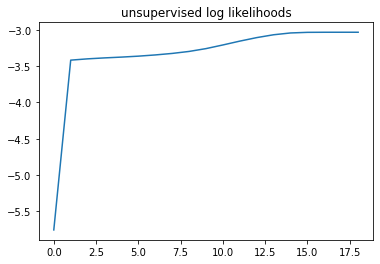

In [100]:
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
#plt.savefig("unsupervised.png")
#plt.close()

In [101]:
unsupervised_loglikelihoods

[-5.754196673865747,
 -3.417455179606569,
 -3.3996270548548586,
 -3.3865801267924853,
 -3.3756019463214835,
 -3.3626384460733085,
 -3.345841910487601,
 -3.325074350699866,
 -3.2976324067882743,
 -3.2588373224708023,
 -3.208530879851638,
 -3.155653609143889,
 -3.107318349581607,
 -3.06810571147126,
 -3.043342740110935,
 -3.034837259721403,
 -3.0336945689528103,
 -3.033521080674623,
 -3.0334736648111296]